<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S10/EVA_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')


In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np


train_transforms = AlbumentationTransforms(
    [ A.Rotate((-30.0, 30.0)),
      A.HorizontalFlip(),
      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      A.Cutout(num_holes=6)])




test_transforms = AlbumentationTransforms([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(trainset)
testloader = dataloader.load(testset)

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship   cat horse   dog


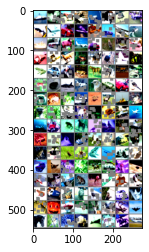

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import evamodel

net = evamodel.ResNet18()

In [0]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F



In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [11]:
import sys
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


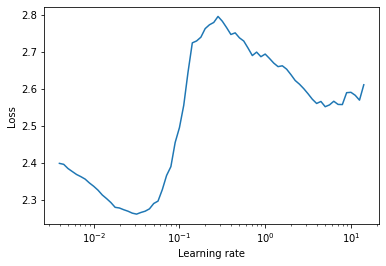

In [12]:
LR = lr_finder.history['lr'][0]

# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [13]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test

model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    val = test(model, device, testloader)
    scheduler.step(val)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.4365108013153076 Batch_id=390 Accuracy=35.77: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5318, Accuracy: 4682/10000 (46.82%)

EPOCH: 1


Loss=1.211812973022461 Batch_id=390 Accuracy=49.85: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4014, Accuracy: 5986/10000 (59.86%)

EPOCH: 2


Loss=1.1358495950698853 Batch_id=390 Accuracy=57.09: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3365, Accuracy: 6635/10000 (66.35%)

EPOCH: 3


Loss=1.0988068580627441 Batch_id=390 Accuracy=62.34: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3058, Accuracy: 6942/10000 (69.42%)

EPOCH: 4


Loss=0.838950514793396 Batch_id=390 Accuracy=66.02: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2926, Accuracy: 7074/10000 (70.74%)

EPOCH: 5


Loss=0.6829950213432312 Batch_id=390 Accuracy=68.49: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2693, Accuracy: 7307/10000 (73.07%)

EPOCH: 6


Loss=0.6569470763206482 Batch_id=390 Accuracy=70.95: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2368, Accuracy: 7632/10000 (76.32%)

EPOCH: 7


Loss=0.8061092495918274 Batch_id=390 Accuracy=72.56: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2173, Accuracy: 7827/10000 (78.27%)

EPOCH: 8


Loss=0.8999192118644714 Batch_id=390 Accuracy=74.26: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2344, Accuracy: 7656/10000 (76.56%)

EPOCH: 9


Loss=0.6802162528038025 Batch_id=390 Accuracy=75.46: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2186, Accuracy: 7814/10000 (78.14%)

EPOCH: 10


Loss=0.8562237024307251 Batch_id=390 Accuracy=76.70: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1958, Accuracy: 8042/10000 (80.42%)

EPOCH: 11


Loss=0.7404705286026001 Batch_id=390 Accuracy=77.62: 100%|██████████| 391/391 [00:41<00:00,  9.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1974, Accuracy: 8026/10000 (80.26%)

EPOCH: 12


Loss=0.6253138184547424 Batch_id=390 Accuracy=78.68: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1953, Accuracy: 8047/10000 (80.47%)

EPOCH: 13


Loss=0.5063059329986572 Batch_id=390 Accuracy=79.66: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1883, Accuracy: 8117/10000 (81.17%)

EPOCH: 14


Loss=0.3627181649208069 Batch_id=390 Accuracy=80.60: 100%|██████████| 391/391 [00:42<00:00,  9.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1613, Accuracy: 8387/10000 (83.87%)

EPOCH: 15


Loss=0.5814825296401978 Batch_id=390 Accuracy=81.26: 100%|██████████| 391/391 [00:42<00:00,  9.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1753, Accuracy: 8247/10000 (82.47%)

EPOCH: 16


Loss=0.7011133432388306 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:42<00:00,  9.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1672, Accuracy: 8328/10000 (83.28%)

EPOCH: 17


Loss=0.6333020925521851 Batch_id=390 Accuracy=82.48: 100%|██████████| 391/391 [00:42<00:00,  9.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1609, Accuracy: 8391/10000 (83.91%)

EPOCH: 18


Loss=0.4658032953739166 Batch_id=390 Accuracy=82.94: 100%|██████████| 391/391 [00:42<00:00,  9.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1585, Accuracy: 8415/10000 (84.15%)

EPOCH: 19


Loss=0.43986910581588745 Batch_id=390 Accuracy=83.44: 100%|██████████| 391/391 [00:41<00:00,  9.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1609, Accuracy: 8391/10000 (83.91%)

EPOCH: 20


Loss=0.46744027733802795 Batch_id=390 Accuracy=84.16: 100%|██████████| 391/391 [00:42<00:00,  9.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1627, Accuracy: 8373/10000 (83.73%)

EPOCH: 21


Loss=0.35075172781944275 Batch_id=390 Accuracy=84.52: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1450, Accuracy: 8550/10000 (85.50%)

EPOCH: 22


Loss=0.3454967439174652 Batch_id=390 Accuracy=85.11: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1526, Accuracy: 8474/10000 (84.74%)

EPOCH: 23


Loss=0.46547168493270874 Batch_id=390 Accuracy=85.38: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1437, Accuracy: 8563/10000 (85.63%)

EPOCH: 24


Loss=0.4469752311706543 Batch_id=390 Accuracy=86.14: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1462, Accuracy: 8538/10000 (85.38%)

EPOCH: 25


Loss=0.34872645139694214 Batch_id=390 Accuracy=86.35: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1454, Accuracy: 8546/10000 (85.46%)

EPOCH: 26


Loss=0.2891765236854553 Batch_id=390 Accuracy=86.73: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1362, Accuracy: 8638/10000 (86.38%)

EPOCH: 27


Loss=0.49089059233665466 Batch_id=390 Accuracy=87.20: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1429, Accuracy: 8571/10000 (85.71%)

EPOCH: 28


Loss=0.4565325379371643 Batch_id=390 Accuracy=87.31: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1463, Accuracy: 8537/10000 (85.37%)

EPOCH: 29


Loss=0.32936349511146545 Batch_id=390 Accuracy=87.73: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1440, Accuracy: 8560/10000 (85.60%)

EPOCH: 30


Loss=0.2759883999824524 Batch_id=390 Accuracy=87.97: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1364, Accuracy: 8636/10000 (86.36%)

EPOCH: 31


Loss=0.4730406403541565 Batch_id=390 Accuracy=88.41: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1372, Accuracy: 8628/10000 (86.28%)

EPOCH: 32


Loss=0.3091927170753479 Batch_id=390 Accuracy=88.77: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1196, Accuracy: 8804/10000 (88.04%)

EPOCH: 33


Loss=0.4280473291873932 Batch_id=390 Accuracy=88.73: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1293, Accuracy: 8707/10000 (87.07%)

EPOCH: 34


Loss=0.3889898657798767 Batch_id=390 Accuracy=89.01: 100%|██████████| 391/391 [00:38<00:00, 10.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1240, Accuracy: 8760/10000 (87.60%)

EPOCH: 35


Loss=0.15747302770614624 Batch_id=390 Accuracy=89.43: 100%|██████████| 391/391 [00:38<00:00, 10.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1266, Accuracy: 8734/10000 (87.34%)

EPOCH: 36


Loss=0.3492463529109955 Batch_id=390 Accuracy=89.86: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1147, Accuracy: 8853/10000 (88.53%)

EPOCH: 37


Loss=0.37886229157447815 Batch_id=390 Accuracy=89.59: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1252, Accuracy: 8748/10000 (87.48%)

EPOCH: 38


Loss=0.39615312218666077 Batch_id=390 Accuracy=89.86: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1273, Accuracy: 8727/10000 (87.27%)

EPOCH: 39


Loss=0.31337758898735046 Batch_id=390 Accuracy=90.12: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1312, Accuracy: 8688/10000 (86.88%)

EPOCH: 40


Loss=0.3313175141811371 Batch_id=390 Accuracy=90.43: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1280, Accuracy: 8720/10000 (87.20%)

EPOCH: 41


Loss=0.15969516336917877 Batch_id=390 Accuracy=90.77: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1281, Accuracy: 8719/10000 (87.19%)

EPOCH: 42


Loss=0.30999132990837097 Batch_id=390 Accuracy=90.70: 100%|██████████| 391/391 [00:38<00:00, 10.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1307, Accuracy: 8693/10000 (86.93%)

EPOCH: 43


Loss=0.35684436559677124 Batch_id=390 Accuracy=91.05: 100%|██████████| 391/391 [00:38<00:00, 10.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1201, Accuracy: 8799/10000 (87.99%)

EPOCH: 44


Loss=0.32697445154190063 Batch_id=390 Accuracy=91.11: 100%|██████████| 391/391 [00:38<00:00, 10.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1255, Accuracy: 8745/10000 (87.45%)

EPOCH: 45


Loss=0.28463637828826904 Batch_id=390 Accuracy=91.27: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1245, Accuracy: 8755/10000 (87.55%)

EPOCH: 46


Loss=0.39949265122413635 Batch_id=390 Accuracy=91.33: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1164, Accuracy: 8836/10000 (88.36%)

EPOCH: 47


Loss=0.2656639814376831 Batch_id=390 Accuracy=91.77: 100%|██████████| 391/391 [00:41<00:00,  9.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1170, Accuracy: 8830/10000 (88.30%)

EPOCH: 48


Loss=0.20193758606910706 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0990, Accuracy: 9010/10000 (90.10%)

EPOCH: 49


Loss=0.1948515623807907 Batch_id=390 Accuracy=93.67: 100%|██████████| 391/391 [00:40<00:00,  9.59it/s]



Test set: Average loss: 0.0976, Accuracy: 9024/10000 (90.24%)



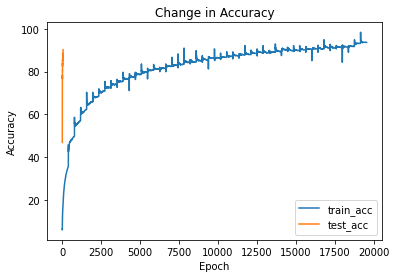

In [14]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

25


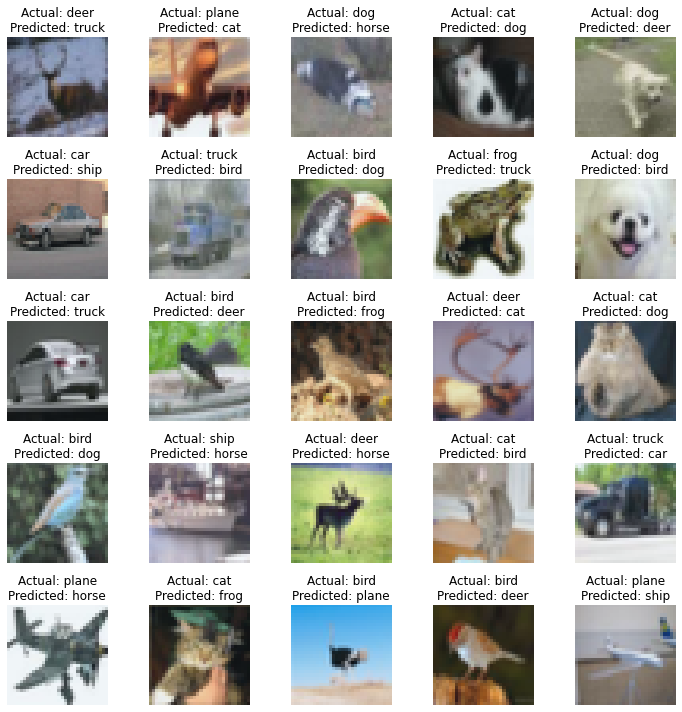

In [16]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

In [0]:
model_save_name = 'model.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [18]:
model_save_name = 'model.pt'
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [19]:
'''
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
'''

'\nprint("Model\'s state_dict:")\nfor param_tensor in model.state_dict():\n    print(param_tensor, "\t", model.state_dict()[param_tensor].size())\n'

In [0]:
import grad_cam as gradcamAbs

In [0]:
config = dict(model_type='resnet', arch=model, layer_name='layer4')
means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [22]:
gradcam_images, pred_results = gcam.applyOnImages(dataloader=testloader, num_of_images=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


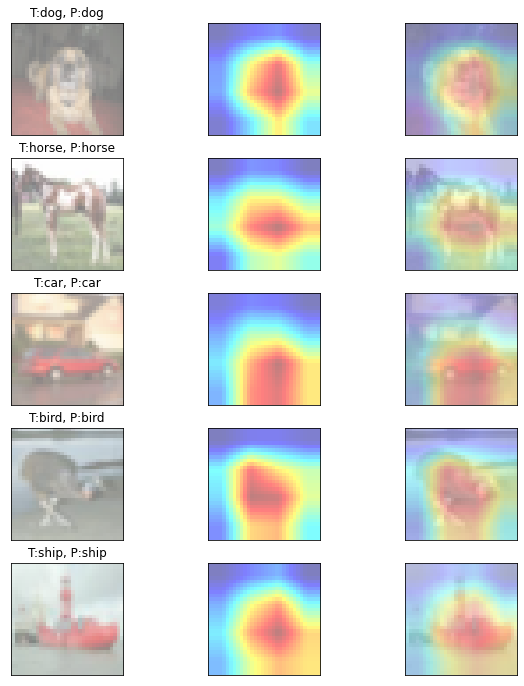

In [23]:
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result")